Import Libraries

In [1]:
import scipy.signal
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import URI
import URI_extra

Load Data

In [2]:
mat = scipy.io.loadmat("preprocess_v3.mat")

Shape Data into usable form

In [ ]:
animal = mat["animal"][0]
exp = mat["exp"][0]
hasCA1 = mat["hasCA1"][0]
hasPF = mat["hasPF"][0]
learned = mat["learned"]
ses = mat["ses"][0]
srate = np.squeeze(mat["srate"])
trainingday = mat["trainingday"][0]

data_lbls = [
    "Spikes",
    "Events",
    "Waveforms",
    "Area",
    "Exp",
    "Animal",
    "Session",
    "RipTS",
    "TrainingDay",
    "Learned",
    "RewardedSound",
]
waveform_lbls = ["wfs", "include", "Depth", "SpikeV2P", "SpikeWidth"]

data = [
    {
        data_lbls[i]: np.array([np.squeeze(list(part)) for part in session[i]])
        for i in range(len(session))
    }
    for session in mat["data"][0]
]

for ses_ind in range(len(data)):
    data[ses_ind]["Waveforms"] = {
        waveform_lbls[i]: np.array(np.squeeze(data[ses_ind]["Waveforms"][0][i][0][0]))
        for i in range(len(data[ses_ind]["Waveforms"][0]))
    }
    data[ses_ind]["Area"] = np.squeeze(data[ses_ind]["Area"])
    data[ses_ind]["Exp"] = np.squeeze(data[ses_ind]["Exp"])
    data[ses_ind]["Animal"] = np.squeeze(data[ses_ind]["Animal"])
    data[ses_ind]["Session"] = np.squeeze(data[ses_ind]["Session"])
    data[ses_ind]["RipTS"] = np.squeeze(data[ses_ind]["RipTS"])
    data[ses_ind]["TrainingDay"] = np.squeeze(data[ses_ind]["TrainingDay"])
    data[ses_ind]["Learned"] = np.squeeze(data[ses_ind]["Learned"])

for i in data_lbls:
    print(f"{i}: \t\t\t{np.shape(data[72][i])}")

Spikes: 			(2, 1489617)
Events: 			(2, 1040)
Waveforms: 			()
Area: 			(111,)
Exp: 			()
Animal: 			()
Session: 			()
RipTS: 			(527,)
TrainingDay: 			()
Learned: 			(2,)
RewardedSound: 			(0,)


In [4]:
def get_bins(before_window=0, after_window=1000, start_point=0):
    return np.arange(
        -before_window + start_point, after_window + start_point + 1
    )  # in ms


def get_spike_matrix(data, sess, bins, stim_idx=None, area_idx=None):
    # Gets the spike matrix of the spikes before and after stimuli
    # data is the data as a list of dictionaries
    # sess is the session index
    # stim_idx is the stimulus index of the desired stimulus
    if stim_idx == None:
        stimuli = (
            data[sess]["Events"][0][
                np.logical_or(
                    data[sess]["Events"][1] == 1, data[sess]["Events"][1] == 2
                )
            ]
            / srate
            * 1000
        )  # in ms
    else:
        stimuli = (
            data[sess]["Events"][0][data[sess]["Events"][1] == stim_idx] / srate * 1000
        )  # in ms

    neurons = np.sort(list(set(data[sess]["Spikes"][1])))
    if area_idx != None:
        neurons = neurons[np.where(data[sess]["Area"] == area_idx)]
    spk_matrix = np.ndarray((len(stimuli), len(neurons), bins.shape[0] - 1))

    for istim, stim in enumerate(stimuli):
        for ineuron, neuron_id in enumerate(neurons):
            idx = data[sess]["Spikes"][1] == neuron_id
            count = np.histogram(
                data[sess]["Spikes"][0][idx] / srate * 1000, bins + stim
            )
            spk_matrix[istim, ineuron, :] = count[0]

    return spk_matrix


def get_tufl(data, sess, stim_idx):
    # Gets the time until first lick after stimulus in ms
    # data is the data as a list of dictionaries
    # s is the session index
    # stim_idx is the stimulus index of the desired stimulus
    stimuli = (
        data[sess]["Events"][0][data[sess]["Events"][1] == stim_idx] / srate * 1000
    )  # in ms
    licks = (
        data[sess]["Events"][0][data[sess]["Events"][1] == 3] / srate * 1000
    )  # in ms
    tufl = np.empty(len(stimuli))  # time until first lick after stimulus in ms
    for istim, stim in enumerate(stimuli):
        if len(licks[licks > stim]) > 0:
            earliest_lick = np.min(licks[licks > stim]) - stim
            if earliest_lick > 30000:
                tufl[istim] = 30000
            else:
                tufl[istim] = earliest_lick
        else:
            tufl[istim] = 30000

    return tufl


def spk_matrix2spk_time(spk_matrix, bins):
    ntrials = spk_matrix.shape[0]
    nneurons = spk_matrix.shape[1]
    spk_time = np.ndarray((ntrials, nneurons), dtype=list)
    for itrial in range(ntrials):
        for ineuron in range(nneurons):
            spk_time[itrial, ineuron] = bins[
                np.argwhere(spk_matrix[itrial, ineuron, :] > 0)[:, 0]
            ]
    return spk_time


def get_pvalue(data, sess, stim, area_idx):
    bins = get_bins()
    CS_plus_spk_matrix = get_spike_matrix(data, sess, stim, area_idx, bins)
    CS_plus_spk_time = spk_matrix2spk_time(CS_plus_spk_matrix, bins)
    CS_plus_URI = URI.getURI(CS_plus_spk_time, 500)
    return CS_plus_URI[1]

In [5]:
sess = 72
bins = get_bins()
CS_plus_spk_matrix = get_spike_matrix(data, sess, bins, 1, 1)
CS_minus_spk_matrix = get_spike_matrix(data, sess, bins, 2, 1)
CS_plus_tufl = get_tufl(data, sess, 1)
CS_minus_tufl = get_tufl(data, sess, 2)
print(CS_plus_tufl.shape)

(44,)


In [6]:
print(CS_plus_spk_matrix.shape)
print(CS_minus_spk_matrix.shape)
print(data[sess]["Area"].shape)

(44, 42, 1000)
(41, 42, 1000)
(111,)


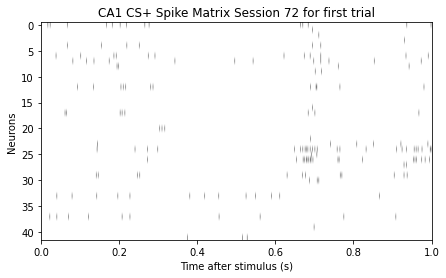

In [7]:
plt.figure(figsize=(7, 4))
plt.imshow(
    CS_plus_spk_matrix[0],
    aspect="auto",
    vmin=0,
    vmax=1,
    cmap="gray_r",
    extent=[0, 1, CS_plus_spk_matrix.shape[1] - 0.5, -0.5],
)
plt.title("CA1 CS+ Spike Matrix Session 72 for first trial")
plt.ylabel("Neurons")
plt.xlabel("Time after stimulus (s)")
plt.show()

In [8]:
stimuli = data[0]["Events"][0][data[0]["Events"][1] == 1] / srate * 1000
print(data[0]["Spikes"][1] == 416)
f = data[0]["Spikes"][0] / srate * 1000
print(np.min(f))
print(np.max(f))
g = np.histogram(
    data[0]["Spikes"][0][data[0]["Spikes"][1] == 416] / srate * 1000,
    get_bins() + stimuli[0],
)[0]
print(np.sum(g))
print(g)

[ True False False ... False False False]
21.133333333333333
5710712.5
9
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [9]:
def calculate_URIs(
    stimulus_spk_matrix, bins, window=100, step_size=50, nr_surrogates=100
):
    window_bins = np.arange(bins[0], bins[-1] - int(window / 2), step_size) - bins[0]
    uri_value = np.empty(len(window_bins))
    p_value = np.empty(len(window_bins))
    for istart, start in enumerate(window_bins):
        stimulus_spk_time = spk_matrix2spk_time(
            stimulus_spk_matrix[:, :, start : start + window],
            bins[start : start + window],
        )
        uri = URI.getURI(stimulus_spk_time, nr_surrogates)
        uri_value[istart] = uri[0]
        p_value[istart] = uri[1]
    return np.array([uri_value, p_value])

In [10]:
a = calculate_URIs(get_spike_matrix(data, 0, bins, 1), bins, nr_surrogates=50)

c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\reubi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in mean (vectorized)
  outputs = ufunc(*inputs)


In [11]:
window = 50
window_bins = np.arange(bins[0], bins[-1] - window, 25) - bins[0]

Calculating URI zscores

In [12]:
# CA1_CS_plus_URIs = np.empty((62, len(window_bins)))
# CA1_CS_minus_URIs = np.empty((62, len(window_bins)))
# for sess in range(41):
#     CA1_CS_plus_URIs[sess, :] = calculate_URIs(get_spike_matrix(data, sess, 1, 1)[0])
#     CA1_CS_minus_URIs[sess, :] = calculate_URIs(get_spike_matrix(data, sess, 2, 1)[0])
# for sess in range(72, 93):
#     CA1_CS_plus_URIs[sess-31, :] = calculate_URIs(get_spike_matrix(data, sess, 1, 1)[0])
#     CA1_CS_minus_URIs[sess-31, :] = calculate_URIs(get_spike_matrix(data, sess, 2, 1)[0])
# np.save('CA1_CS_plus_URIs2', CA1_CS_plus_URIs)
# np.save('CA1_CS_minus_URIs2', CA1_CS_minus_URIs)

In [13]:
# mPFC_CS_plus_URIs = np.empty((52, len(window_bins)))
# mPFC_CS_minus_URIs = np.empty((52, len(window_bins)))
# for sess in range(41, 93):
#     mPFC_CS_plus_URIs[sess-41, :] = calculate_URIs(get_spike_matrix(data, sess, 1, 2)[0])
#     mPFC_CS_minus_URIs[sess-41, :] = calculate_URIs(get_spike_matrix(data, sess, 2, 2)[0])
# np.save('mPFC_CS_plus_URIs2', mPFC_CS_plus_URIs)
# np.save('mPFC_CS_minus_URIs2', mPFC_CS_minus_URIs)

In [14]:
CA1_CS_plus_URIs = np.load("URIs_zscores\CA1_CS_plus_URIs2.npy")
CA1_CS_minus_URIs = np.load("URIs_zscores\CA1_CS_minus_URIs2.npy")
mPFC_CS_plus_URIs = np.load("URIs_zscores\mPFC_CS_plus_URIs2.npy")
mPFC_CS_minus_URIs = np.load("URIs_zscores\mPFC_CS_minus_URIs2.npy")

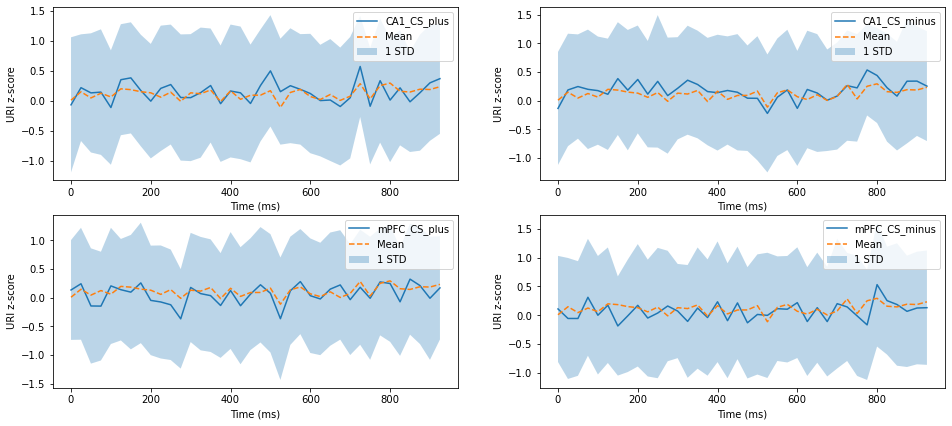

In [15]:
URIs = np.empty((2, 2, len(window_bins)))
URIs[0, 0, :] = np.nanmean(CA1_CS_plus_URIs, axis=0)
URIs[0, 1, :] = np.nanmean(CA1_CS_minus_URIs, axis=0)
URIs[1, 0, :] = np.nanmean(mPFC_CS_plus_URIs, axis=0)
URIs[1, 1, :] = np.nanmean(mPFC_CS_minus_URIs, axis=0)

URI_stds = np.empty((2, 2, len(window_bins)))
URI_stds[0, 0, :] = np.nanstd(CA1_CS_plus_URIs, axis=0)
URI_stds[0, 1, :] = np.nanstd(CA1_CS_minus_URIs, axis=0)
URI_stds[1, 0, :] = np.nanstd(mPFC_CS_plus_URIs, axis=0)
URI_stds[1, 1, :] = np.nanstd(mPFC_CS_minus_URIs, axis=0)

mean_URIs = np.nanmean(
    np.concatenate(
        (CA1_CS_plus_URIs, CA1_CS_minus_URIs, mPFC_CS_plus_URIs, mPFC_CS_minus_URIs)
    ),
    axis=0,
)

URIs_means = np.empty((2, 2, len(window_bins)))
URIs_means[0, 0, :] = np.nanmean(
    np.concatenate((CA1_CS_plus_URIs, CA1_CS_minus_URIs)), axis=0
)
URIs_means[0, 1, :] = np.nanmean(
    np.concatenate((mPFC_CS_plus_URIs, mPFC_CS_minus_URIs)), axis=0
)
URIs_means[1, 0, :] = np.nanmean(
    np.concatenate((CA1_CS_plus_URIs, mPFC_CS_plus_URIs)), axis=0
)
URIs_means[1, 1, :] = np.nanmean(
    np.concatenate((CA1_CS_minus_URIs, mPFC_CS_minus_URIs)), axis=0
)

URIs_means_stds = np.empty((2, 2, len(window_bins)))
URIs_means_stds[0, 0, :] = np.nanstd(
    np.concatenate((CA1_CS_plus_URIs, CA1_CS_minus_URIs)), axis=0
)
URIs_means_stds[0, 1, :] = np.nanstd(
    np.concatenate((mPFC_CS_plus_URIs, mPFC_CS_minus_URIs)), axis=0
)
URIs_means_stds[1, 0, :] = np.nanstd(
    np.concatenate((CA1_CS_plus_URIs, mPFC_CS_plus_URIs)), axis=0
)
URIs_means_stds[1, 1, :] = np.nanstd(
    np.concatenate((CA1_CS_minus_URIs, mPFC_CS_minus_URIs)), axis=0
)

lbls = ["CA1_CS_plus", "CA1_CS_minus", "mPFC_CS_plus", "mPFC_CS_minus"]
plt.figure(figsize=(16, 7))
for i in range(2):
    for j in range(2):
        plt.subplot(221 + 2 * i + j)
        plt.plot(window_bins, URIs[i, j], label=lbls[2 * i + j])
        plt.fill_between(
            window_bins,
            URIs[i, j] - URI_stds[i, j],
            URIs[i, j] + URI_stds[i, j],
            alpha=0.3,
            label="1 STD",
        )
        plt.plot(window_bins, mean_URIs, "--", label="Mean")
        plt.legend()
        plt.ylabel("URI z-score")
        plt.xlabel("Time (ms)")
plt.show()

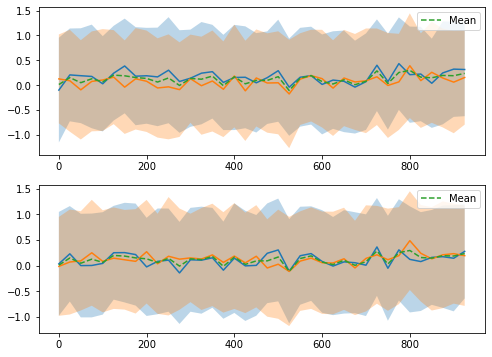

In [16]:
plt.figure(figsize=(8, 6))
for i in range(2):
    plt.subplot(211 + i)
    for j in range(2):
        plt.plot(window_bins, URIs_means[i, j])
        plt.fill_between(
            window_bins,
            URIs_means[i, j] - URIs_means_stds[i, j],
            URIs_means[i, j] + URIs_means_stds[i, j],
            alpha=0.3,
        )
    plt.plot(window_bins, mean_URIs, "--", label="Mean")
    plt.legend()
plt.show()

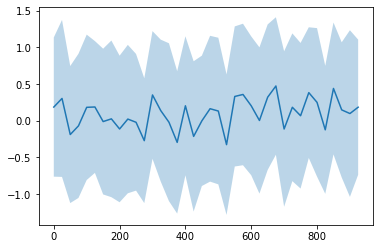

In [17]:
mask = np.nan_to_num(learned[41:, 0]).astype(bool)
learned_URI = np.nanmean(mPFC_CS_plus_URIs[mask], axis=0)
learned_URI_std = np.nanstd(mPFC_CS_plus_URIs[mask], axis=0)
plt.plot(window_bins, learned_URI)
plt.fill_between(
    window_bins, learned_URI - learned_URI_std, learned_URI + learned_URI_std, alpha=0.3
)
plt.show()

In [18]:
def get_br_corr(sess):
    bins = get_bins()
    sm = [
        get_spike_matrix(data, sess, j + 1, i + 1, bins)
        for j in range(2)
        for i in range(2)
    ]
    st = [spk_matrix2spk_time(i, bins) for i in sm]
    OccAll = [URI.getURI(i, 1)[2].flatten() for i in st]
    OccInd = [
        np.array([URI.getURI(np.array([j]), 1)[2].flatten() for j in i]) for i in st
    ]
    trial_to_occ_corr = [
        np.nan_to_num([np.corrcoef(OccAll[i], j)[1, 0] for j in OccInd[i]])
        for i in range(4)
    ]
    brain_region_corr = np.array(
        [
            np.corrcoef(trial_to_occ_corr[0], trial_to_occ_corr[1])[1, 0],
            np.corrcoef(trial_to_occ_corr[2], trial_to_occ_corr[3])[1, 0],
        ]
    )
    return brain_region_corr

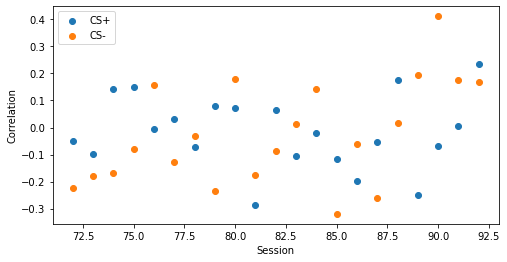

[-0.0175821  -0.02321221]


In [19]:
# brain_region_corrs = np.array([get_br_corr(sess) for sess in range(72, 93)])
# np.save('brain_region_corrs', brain_region_corrs)
brain_region_corrs = np.load("brain_region_corrs.npy")
plt.figure(figsize=(8, 4))
plt.scatter(np.arange(72, 93, 1), brain_region_corrs[:, 0], label="CS+")
plt.scatter(np.arange(72, 93, 1), brain_region_corrs[:, 1], label="CS-")
plt.xlabel("Session")
plt.ylabel("Correlation")
plt.legend()
plt.show()
print(np.mean(brain_region_corrs, axis=0))

In [20]:
bins = get_bins()
sm88 = [
    get_spike_matrix(data, 88, bins, j + 1, i + 1) for j in range(2) for i in range(2)
]
st88 = [spk_matrix2spk_time(i, bins) for i in sm88]
Occ88All = [URI.getURI(i, 1)[2].flatten() for i in st88]
Occ88Ind = [
    np.array([URI.getURI(np.array([j]), 1)[2].flatten() for j in i]) for i in st88
]

c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\reubi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in mean (vectorized)
  outputs = ufunc(*inputs)


In [21]:
fr = URI.firing_ranks(st88[0])
print(fr.shape)
occ = URI.firing_ranks2occ_matrix(fr)
seq = URI_extra.construct_sequence(fr, fr.shape[1], 200)
print(sm88[0].shape)
print(occ.shape)
print(seq[0])

(49, 12)
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
(49, 12, 1000)
(12, 12)
10


In [22]:
n_trials = len(st88[0])
fr = np.array([URI.firing_ranks(np.array([st88[0][i]])) for i in range(n_trials)])
seq = np.array(
    [
        URI_extra.construct_sequence(fr[i], fr[i].shape[1], 200)[0]
        for i in range(n_trials)
    ]
)
print(sm88[0].shape)
print(fr[0].shape)
print(seq)

NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIGHEST MI DECREASE ARE USED.
NO SIGNIFICANT NEURONS FOUND, 2 NEURONS WITH THE HIG

(49,)
(49,)
(43,)
(43,)


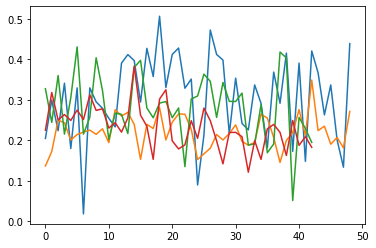

[0.41203321 0.21825651]


In [23]:
a = [
    np.nan_to_num([np.corrcoef(Occ88All[i], j)[1, 0] for j in Occ88Ind[i]])
    for i in range(4)
]
for i in range(4):
    print(a[i].shape)
    plt.plot(a[i])

plt.show()
b = np.array([np.corrcoef(a[0], a[1])[1, 0], np.corrcoef(a[2], a[3])[1, 0]])
print(b)

In [24]:
# p_values = np.array([[[get_pvalue(data, sess, stim, area) for sess in range(72, 93)] for stim in range(1, 3)] for area in range(1, 3)])

In [25]:
# np.save('p_values', p_values)
p_values = np.load("p_values.npy")
print(np.array(np.where(p_values < 0.05)))

[[ 0  0  0  1  1  1  1]
 [ 0  1  1  0  0  1  1]
 [18  4 16 14 17  3 12]]


c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\reubi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in mean (vectorized)
  outputs = ufunc(*inputs)


(56, 15, 1000)
(2, 19)


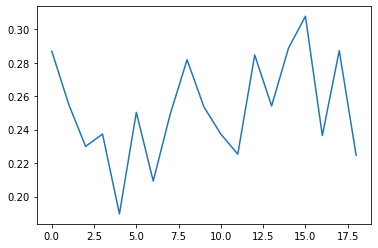

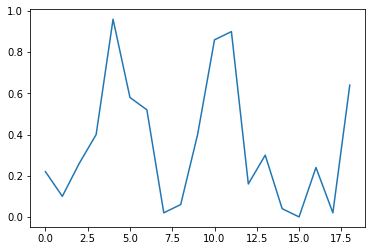

In [26]:
# Calculating the p-value and URI of different time windows per session, stimulus and area
bins = get_bins()
a = get_spike_matrix(data, 0, bins, 2)
b = calculate_URIs(a, bins, nr_surrogates=50)
print(a.shape)
print(b.shape)
plt.plot(b[0])
plt.show()
plt.plot(b[1])
plt.show()

# Then calculating the sequence and see per trial if it has that sequence

# Compare the timing differences of brain areas average across all sessions.

# NOTE: Z-score looks like the inverse of p-value

In [27]:
# CA1_pos_stats = np.array([[calculate_URIs(get_spike_matrix(data, sess, bins, stim), bins, nr_surrogates=200) for stim in range(1, 3)] for sess in range(41)]) # Shape: 41x2x2x18
# np.save('CA1_pos_stats', CA1_pos_stats)
# 12m 9.8s (50)
# 32m 51.2s (200)
# 31m 28.2s (200)
CA1_pos_stats = np.load("CA1_pos_stats.npy")

In [28]:
# mPFC_pos_stats = np.array([[calculate_URIs(get_spike_matrix(data, sess, bins, stim), bins, nr_surrogates=200) for stim in range(1, 3)] for sess in range(41, 72)]) # Shape: 31x2x2x18
# np.save('mPFC_pos_stats', mPFC_pos_stats)
# 15m 2.8s (50)
# 55m 14.6s (200)
# 40m 20.1s (200)
mPFC_pos_stats = np.load("mPFC_pos_stats.npy")

In [29]:
# both_pos_stats = np.array([[[calculate_URIs(get_spike_matrix(data, sess, bins, stim, area), bins, nr_surrogates=200) for stim in range(1, 3)] for area in range(1, 3)] for sess in range(72, 93)]) # Shape: 21x2x2x2x18
# np.save('both_pos_stats', both_pos_stats)
# 12m 32.7s (50)
# 42m 59.2s (200)
# 31m 38.5s (200)
both_pos_stats = np.load("both_pos_stats.npy")

In [30]:
side_bins = get_bins(100, 0)
# side_both_pos_stats = np.squeeze(np.array([[[calculate_URIs(get_spike_matrix(data, sess, side_bins, stim, area), side_bins, nr_surrogates=10) for stim in range(1, 3)] for area in range(1, 3)] for sess in range(72, 93)])) # Shape: 21x2x2x2
# np.save('side_both_pos_stats', side_both_pos_stats)
side_both_pos_stats = np.load("side_both_pos_stats.npy")

In [31]:
# side_CA1_pos_stats = np.squeeze(np.array([[calculate_URIs(get_spike_matrix(data, sess, side_bins, stim), side_bins, nr_surrogates=10) for stim in range(1, 3)] for sess in range(41)]))
# np.save('side_CA1_pos_stats', side_CA1_pos_stats)
side_CA1_pos_stats = np.load("side_CA1_pos_stats.npy")

In [32]:
# side_mPFC_pos_stats = np.squeeze(np.array([[calculate_URIs(get_spike_matrix(data, sess, side_bins, stim), side_bins, nr_surrogates=10) for stim in range(1, 3)] for sess in range(41, 72)]))
# np.save('side_mPFC_pos_stats', side_mPFC_pos_stats)
side_mPFC_pos_stats = np.load("side_mPFC_pos_stats.npy")

In [33]:
both_pos_stats_URI = (
    both_pos_stats[:, :, :, 0].T - side_both_pos_stats[:, :, :, 0].T
).T
both_pos_stats[:, :, :, 0] = both_pos_stats_URI

CA1_pos_stats_URI = (CA1_pos_stats[:, :, 0].T - side_CA1_pos_stats[:, :, 0].T).T
CA1_pos_stats[:, :, 0] = CA1_pos_stats_URI

mPFC_pos_stats_URI = (mPFC_pos_stats[:, :, 0].T - side_mPFC_pos_stats[:, :, 0].T).T
mPFC_pos_stats[:, :, 0] = mPFC_pos_stats_URI

In [34]:
window_mids = list(range(50, 1000, 50))
all_CA1_pos_stats = np.concatenate((CA1_pos_stats, both_pos_stats[:, 0]))
all_mPFC_pos_stats = np.concatenate((mPFC_pos_stats, both_pos_stats[:, 1]))
print(window_mids)
print(all_CA1_pos_stats.shape)
print(all_mPFC_pos_stats.shape)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]
(62, 2, 2, 19)
(52, 2, 2, 19)


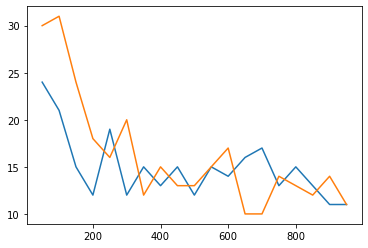

In [35]:
CA1_sign_idx = np.tile(all_CA1_pos_stats[:, :, 1] < 0.05, 2).reshape(
    all_CA1_pos_stats.shape
)
mPFC_sign_idx = np.tile(all_mPFC_pos_stats[:, :, 1] < 0.05, 2).reshape(
    all_mPFC_pos_stats.shape
)

CA1_p_count = np.sum(CA1_sign_idx[:, 0], axis=0)
mPFC_p_count = np.sum(mPFC_sign_idx[:, 0], axis=0)

plt.plot(window_mids, CA1_p_count[0])
plt.plot(window_mids, mPFC_p_count[0])
plt.show()

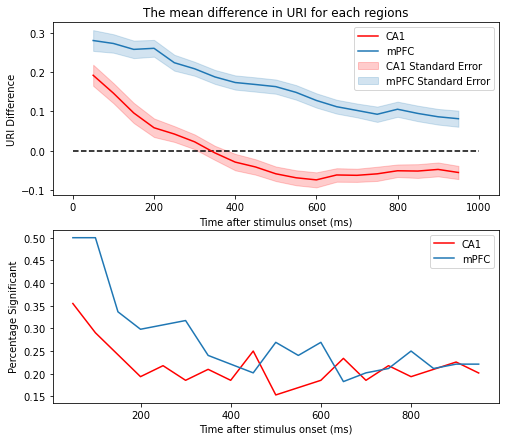

In [36]:
CA1_mean_stats = np.mean(all_CA1_pos_stats, axis=(0, 1))
mPFC_mean_stats = np.mean(all_mPFC_pos_stats, axis=(0, 1))

CA1_ste_stats = np.std(all_CA1_pos_stats, axis=(0, 1)) / np.sqrt(
    all_CA1_pos_stats.shape[0] * all_CA1_pos_stats.shape[1]
)
mPFC_ste_stats = np.std(all_mPFC_pos_stats, axis=(0, 1)) / np.sqrt(
    all_mPFC_pos_stats.shape[0] * all_mPFC_pos_stats.shape[1]
)

titles = ["URI", "p-value"]
plt.figure(figsize=(8, 7))
plt.subplot(211)
plt.plot(window_mids, CA1_mean_stats[0], label="CA1", color="r")
plt.fill_between(
    window_mids,
    CA1_mean_stats[0] - CA1_ste_stats[0],
    CA1_mean_stats[0] + CA1_ste_stats[0],
    alpha=0.2,
    label="CA1 Standard Error",
    color="r",
)
plt.plot(window_mids, mPFC_mean_stats[0], label="mPFC", color="C0")
plt.fill_between(
    window_mids,
    mPFC_mean_stats[0] - mPFC_ste_stats[0],
    mPFC_mean_stats[0] + mPFC_ste_stats[0],
    alpha=0.2,
    label="mPFC Standard Error",
    color="C0",
)
plt.hlines(0, 0, 1000, linestyles="--", colors="black")
plt.ylabel("URI Difference")
plt.xlabel("Time after stimulus onset (ms)")
plt.title("The mean difference in URI for each regions")
plt.legend()

plt.subplot(212)
plt.plot(
    window_mids,
    np.sum(all_CA1_pos_stats[:, :, 1] < 0.05, axis=(0, 1))
    / (all_CA1_pos_stats.shape[0] * all_CA1_pos_stats.shape[1]),
    label="CA1",
    color="r",
)
plt.plot(
    window_mids,
    np.sum(all_mPFC_pos_stats[:, :, 1] < 0.05, axis=(0, 1))
    / (all_mPFC_pos_stats.shape[0] * all_mPFC_pos_stats.shape[1]),
    label="mPFC",
    color="C0",
)
plt.ylabel("Percentage Significant")
plt.xlabel("Time after stimulus onset (ms)")
plt.legend()
plt.show()

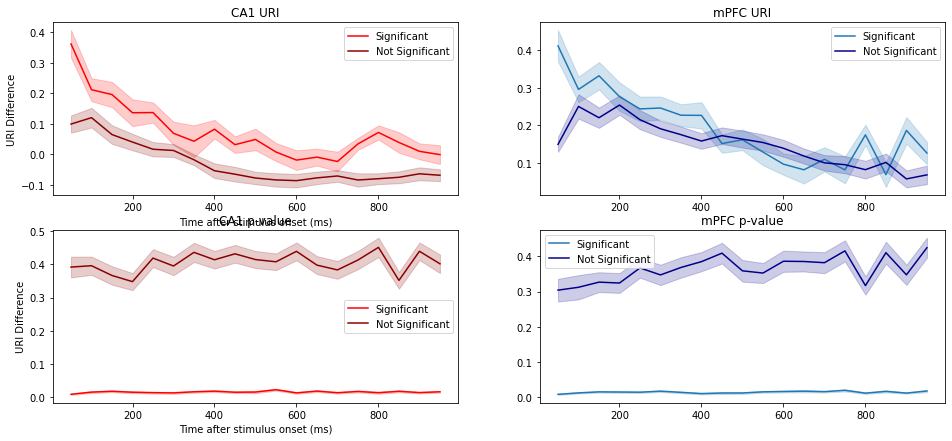

In [37]:
CA1_sign_mean_stats = np.mean(all_CA1_pos_stats, axis=(0, 1), where=CA1_sign_idx)
mPFC_sign_mean_stats = np.mean(all_mPFC_pos_stats, axis=(0, 1), where=mPFC_sign_idx)
CA1_notsign_mean_stats = np.mean(
    all_CA1_pos_stats, axis=(0, 1), where=np.logical_not(CA1_sign_idx)
)
mPFC_notsign_mean_stats = np.mean(
    all_mPFC_pos_stats, axis=(0, 1), where=np.logical_not(mPFC_sign_idx)
)

CA1_sign_ste_stats = np.std(
    all_CA1_pos_stats, axis=(0, 1), where=CA1_sign_idx
) / np.sqrt(np.sum(CA1_sign_idx, axis=(0, 1)))
mPFC_sign_ste_stats = np.std(
    all_mPFC_pos_stats, axis=(0, 1), where=mPFC_sign_idx
) / np.sqrt(np.sum(mPFC_sign_idx, axis=(0, 1)))
CA1_notsign_ste_stats = np.std(
    all_CA1_pos_stats, axis=(0, 1), where=np.logical_not(CA1_sign_idx)
) / np.sqrt(np.sum(np.logical_not(CA1_sign_idx), axis=(0, 1)))
mPFC_notsign_ste_stats = np.std(
    all_mPFC_pos_stats, axis=(0, 1), where=np.logical_not(mPFC_sign_idx)
) / np.sqrt(np.sum(np.logical_not(mPFC_sign_idx), axis=(0, 1)))

titles = ["URI", "p-value"]
areas = ["CA1", "mPFC"]
fig = plt.figure(figsize=(16, 7))
for i in range(2):
    plt.subplot(221 + i * 2)
    plt.plot(window_mids, CA1_sign_mean_stats[i], label="Significant", color="r")
    plt.fill_between(
        window_mids,
        CA1_sign_mean_stats[i] - CA1_sign_ste_stats[i],
        CA1_sign_mean_stats[i] + CA1_sign_ste_stats[i],
        alpha=0.2,
        color="r",
    )
    plt.plot(
        window_mids, CA1_notsign_mean_stats[i], label="Not Significant", color="darkred"
    )
    plt.fill_between(
        window_mids,
        CA1_notsign_mean_stats[i] - CA1_notsign_ste_stats[i],
        CA1_notsign_mean_stats[i] + CA1_notsign_ste_stats[i],
        alpha=0.2,
        color="darkred",
    )
    plt.title(areas[0] + " " + titles[i])
    plt.ylabel("URI Difference")
    plt.xlabel("Time after stimulus onset (ms)")
    plt.legend()

    plt.subplot(222 + i * 2)
    plt.plot(window_mids, mPFC_sign_mean_stats[i], label="Significant", color="C0")
    plt.fill_between(
        window_mids,
        mPFC_sign_mean_stats[i] - mPFC_sign_ste_stats[i],
        mPFC_sign_mean_stats[i] + mPFC_sign_ste_stats[i],
        alpha=0.2,
        color="C0",
    )
    plt.plot(
        window_mids,
        mPFC_notsign_mean_stats[i],
        label="Not Significant",
        color="darkblue",
    )
    plt.fill_between(
        window_mids,
        mPFC_notsign_mean_stats[i] - mPFC_notsign_ste_stats[i],
        mPFC_notsign_mean_stats[i] + mPFC_notsign_ste_stats[i],
        alpha=0.2,
        color="darkblue",
    )
    plt.title(areas[1] + " " + titles[i])
    plt.legend()
plt.show()

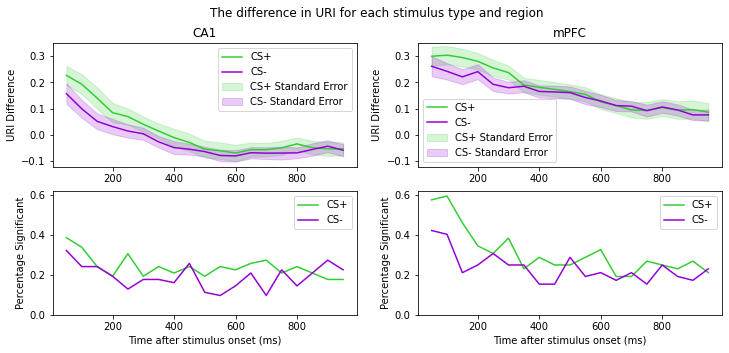

In [38]:
CA1_mean_stats = np.mean(all_CA1_pos_stats, axis=0)
mPFC_mean_stats = np.mean(all_mPFC_pos_stats, axis=0)

CA1_ste_stats = np.std(all_CA1_pos_stats, axis=0) / np.sqrt(all_CA1_pos_stats.shape[0])
mPFC_ste_stats = np.std(all_mPFC_pos_stats, axis=0) / np.sqrt(
    all_mPFC_pos_stats.shape[0]
)

titles = ["URI", "p-value"]
areas = ["CA1", "mPFC"]
plt.figure(figsize=(12, 5))
plt.suptitle("The difference in URI for each stimulus type and region")
plt.subplot(221)
plt.plot(window_mids, CA1_mean_stats[0, 0], label="CS+", color="limegreen")
plt.fill_between(
    window_mids,
    CA1_mean_stats[0, 0] - CA1_ste_stats[0, 0],
    CA1_mean_stats[0, 0] + CA1_ste_stats[0, 0],
    alpha=0.2,
    label="CS+ Standard Error",
    color="limegreen",
)
plt.plot(window_mids, CA1_mean_stats[1, 0], label="CS-", color="darkviolet")
plt.fill_between(
    window_mids,
    CA1_mean_stats[1, 0] - CA1_ste_stats[1, 0],
    CA1_mean_stats[1, 0] + CA1_ste_stats[1, 0],
    alpha=0.2,
    label="CS- Standard Error",
    color="darkviolet",
)
plt.title(areas[0])
plt.ylabel("URI Difference")
plt.ylim(-0.12, 0.35)
plt.legend()

plt.subplot(222)
plt.plot(window_mids, mPFC_mean_stats[0, 0], label="CS+", color="limegreen")
plt.fill_between(
    window_mids,
    mPFC_mean_stats[0, 0] - mPFC_ste_stats[0, 0],
    mPFC_mean_stats[0, 0] + mPFC_ste_stats[0, 0],
    alpha=0.2,
    label="CS+ Standard Error",
    color="limegreen",
)
plt.plot(window_mids, mPFC_mean_stats[1, 0], label="CS-", color="darkviolet")
plt.fill_between(
    window_mids,
    mPFC_mean_stats[1, 0] - mPFC_ste_stats[1, 0],
    mPFC_mean_stats[1, 0] + mPFC_ste_stats[1, 0],
    alpha=0.2,
    label="CS- Standard Error",
    color="darkviolet",
)
plt.title(areas[1])
plt.ylabel("URI Difference")
plt.ylim(-0.12, 0.35)
plt.legend()

plt.subplot(223)
plt.plot(
    window_mids,
    np.sum(all_CA1_pos_stats[:, :, 1] < 0.05, axis=0)[0] / (all_CA1_pos_stats.shape[0]),
    label="CS+",
    color="limegreen",
)
plt.plot(
    window_mids,
    np.sum(all_CA1_pos_stats[:, :, 1] < 0.05, axis=0)[1] / (all_CA1_pos_stats.shape[0]),
    label="CS-",
    color="darkviolet",
)
plt.ylabel("Percentage Significant")
plt.xlabel("Time after stimulus onset (ms)")
plt.ylim(0, 0.62)
plt.legend()

plt.subplot(224)
plt.plot(
    window_mids,
    np.sum(all_mPFC_pos_stats[:, :, 1] < 0.05, axis=0)[0]
    / (all_mPFC_pos_stats.shape[0]),
    label="CS+",
    color="limegreen",
)
plt.plot(
    window_mids,
    np.sum(all_mPFC_pos_stats[:, :, 1] < 0.05, axis=0)[1]
    / (all_mPFC_pos_stats.shape[0]),
    label="CS-",
    color="darkviolet",
)
plt.ylabel("Percentage Significant")
plt.xlabel("Time after stimulus onset (ms)")
plt.ylim(0, 0.62)
plt.legend()

plt.show()

In [39]:
print(learned[:, 0])
CA1_learned = CA1_pos_stats[np.where(learned[:41, 0] == 1)]
mPFC_learned = mPFC_pos_stats[np.where(learned[41:72, 0] == 1)]
both_learned = both_pos_stats[np.where(learned[72:, 0] == 1)]

CA1_not_learned = CA1_pos_stats[np.where(learned[:41, 0] == 0)]
mPFC_not_learned = mPFC_pos_stats[np.where(learned[41:72, 0] == 0)]
both_not_learned = both_pos_stats[np.where(learned[72:, 0] == 0)]

all_CA1_learned = np.concatenate((CA1_learned, both_learned[:, 0]))
all_mPFC_learned = np.concatenate((mPFC_learned, both_learned[:, 1]))
all_CA1_not_learned = np.concatenate((CA1_not_learned, both_not_learned[:, 0]))
all_mPFC_not_learned = np.concatenate((mPFC_not_learned, both_not_learned[:, 1]))

print(all_CA1_learned.shape)

[ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.
  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.
  0.  1.  0.  1.  1. nan  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0. nan  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  1.]
(38, 2, 2, 19)


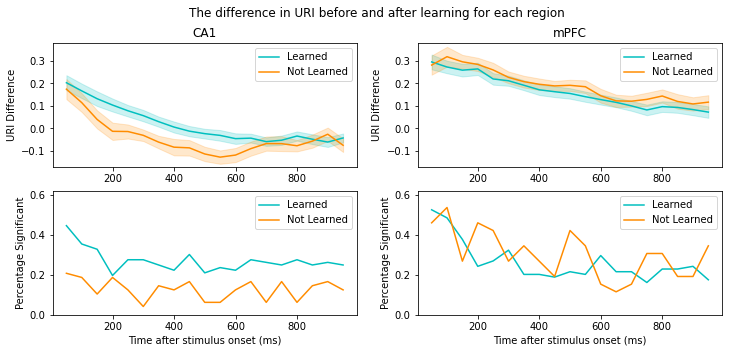

In [40]:
CA1_learned_mean_stats = np.mean(all_CA1_learned, axis=(0, 1))
mPFC_learned_mean_stats = np.mean(all_mPFC_learned, axis=(0, 1))
CA1_notlearned_mean_stats = np.mean(all_CA1_not_learned, axis=(0, 1))
mPFC_notlearned_mean_stats = np.mean(all_mPFC_not_learned, axis=(0, 1))

CA1_learned_ste_stats = np.std(all_CA1_learned, axis=(0, 1)) / np.sqrt(
    all_CA1_learned.shape[0] * all_CA1_learned.shape[1]
)
mPFC_learned_ste_stats = np.std(all_mPFC_learned, axis=(0, 1)) / np.sqrt(
    all_mPFC_learned.shape[0] * all_mPFC_learned.shape[1]
)
CA1_notlearned_ste_stats = np.std(all_CA1_not_learned, axis=(0, 1)) / np.sqrt(
    all_CA1_not_learned.shape[0] * all_CA1_not_learned.shape[1]
)
mPFC_notlearned_ste_stats = np.std(all_mPFC_not_learned, axis=(0, 1)) / np.sqrt(
    all_mPFC_not_learned.shape[0] * all_mPFC_not_learned.shape[1]
)

titles = ["URI", "p-value"]
areas = ["CA1", "mPFC"]
plt.figure(figsize=(12, 5))
plt.suptitle("The difference in URI before and after learning for each region")
plt.subplot(221)
plt.plot(window_mids, CA1_learned_mean_stats[0], label="Learned", color="c")
plt.fill_between(
    window_mids,
    CA1_learned_mean_stats[0] - CA1_learned_ste_stats[0],
    CA1_learned_mean_stats[0] + CA1_learned_ste_stats[0],
    alpha=0.2,
    color="c",
)
plt.plot(
    window_mids, CA1_notlearned_mean_stats[0], label="Not Learned", color="darkorange"
)
plt.fill_between(
    window_mids,
    CA1_notlearned_mean_stats[0] - CA1_notlearned_ste_stats[0],
    CA1_notlearned_mean_stats[0] + CA1_notlearned_ste_stats[0],
    alpha=0.2,
    color="darkorange",
)
plt.title(areas[0])
plt.ylabel("URI Difference")
plt.ylim(-0.17, 0.38)
plt.legend()

plt.subplot(222)
plt.plot(window_mids, mPFC_learned_mean_stats[0], label="Learned", color="c")
plt.fill_between(
    window_mids,
    mPFC_learned_mean_stats[0] - mPFC_learned_ste_stats[0],
    mPFC_learned_mean_stats[0] + mPFC_learned_ste_stats[0],
    alpha=0.2,
    color="c",
)
plt.plot(
    window_mids, mPFC_notlearned_mean_stats[0], label="Not Learned", color="darkorange"
)
plt.fill_between(
    window_mids,
    mPFC_notlearned_mean_stats[0] - mPFC_notlearned_ste_stats[0],
    mPFC_notlearned_mean_stats[0] + mPFC_notlearned_ste_stats[0],
    alpha=0.2,
    color="darkorange",
)
plt.title(areas[1])
plt.ylabel("URI Difference")
plt.ylim(-0.17, 0.38)
plt.legend()

plt.subplot(223)
plt.plot(
    window_mids,
    np.sum(all_CA1_learned[:, :, 1] < 0.05, axis=(0, 1))
    / (all_CA1_learned.shape[0] * all_CA1_learned.shape[1]),
    label="Learned",
    color="c",
)
plt.plot(
    window_mids,
    np.sum(all_CA1_not_learned[:, :, 1] < 0.05, axis=(0, 1))
    / (all_CA1_not_learned.shape[0] * all_CA1_not_learned.shape[1]),
    label="Not Learned",
    color="darkorange",
)
plt.ylabel("Percentage Significant")
plt.xlabel("Time after stimulus onset (ms)")
plt.ylim(0, 0.62)
plt.legend()

plt.subplot(224)
plt.plot(
    window_mids,
    np.sum(all_mPFC_learned[:, :, 1] < 0.05, axis=(0, 1))
    / (all_mPFC_learned.shape[0] * all_mPFC_learned.shape[1]),
    label="Learned",
    color="c",
)
plt.plot(
    window_mids,
    np.sum(all_mPFC_not_learned[:, :, 1] < 0.05, axis=(0, 1))
    / (all_mPFC_not_learned.shape[0] * all_mPFC_not_learned.shape[1]),
    label="Not Learned",
    color="darkorange",
)
plt.ylabel("Percentage Significant")
plt.xlabel("Time after stimulus onset (ms)")
plt.ylim(0, 0.62)
plt.legend()


plt.show()

In [41]:
# # Continue with this if extra time allows

# CA1_learned_mean_stats = np.mean(all_CA1_learned, axis=0)
# mPFC_learned_mean_stats = np.mean(all_mPFC_learned, axis=0)
# CA1_notlearned_mean_stats = np.mean(all_CA1_not_learned, axis=0)
# mPFC_notlearned_mean_stats = np.mean(all_mPFC_not_learned, axis=0)

# CA1_learned_ste_stats = np.std(all_CA1_learned, axis=0)/np.sqrt(all_CA1_learned.shape[0])
# mPFC_learned_ste_stats = np.std(all_mPFC_learned, axis=0)/np.sqrt(all_mPFC_learned.shape[0])
# CA1_notlearned_ste_stats = np.std(all_CA1_not_learned, axis=0)/np.sqrt(all_CA1_not_learned.shape[0])
# mPFC_notlearned_ste_stats = np.std(all_mPFC_not_learned, axis=0)/np.sqrt(all_mPFC_not_learned.shape[0])

# titles = ['URI', 'p-value']
# areas = ['CA1', 'mPFC']
# fig=plt.figure(figsize=(16, 7))
# plt.subplot(221)
# plt.plot(window_mids, CA1_learned_mean_stats[0], label='Learned', color='c')
# plt.fill_between(window_mids, CA1_learned_mean_stats[0] - CA1_learned_ste_stats[0], CA1_learned_mean_stats[0] + CA1_learned_ste_stats[0], alpha=0.2, color='c')
# plt.plot(window_mids, CA1_notlearned_mean_stats[0], label='Not Learned', color='darkorange')
# plt.fill_between(window_mids, CA1_notlearned_mean_stats[0] - CA1_notlearned_ste_stats[0], CA1_notlearned_mean_stats[0] + CA1_notlearned_ste_stats[0], alpha=0.2, color='darkorange')
# plt.title(areas[0] + ' ' + titles[0])
# plt.ylabel('URI Difference')
# plt.xlabel('Time after stimulus onset (ms)')
# plt.legend()

# plt.subplot(222)
# plt.plot(window_mids, mPFC_learned_mean_stats[0], label='Learned', color='c')
# plt.fill_between(window_mids, mPFC_learned_mean_stats[0] - mPFC_learned_ste_stats[0], mPFC_learned_mean_stats[0] + mPFC_learned_ste_stats[0], alpha=0.2, color='c')
# plt.plot(window_mids, mPFC_notlearned_mean_stats[0], label='Not Learned', color='darkorange')
# plt.fill_between(window_mids, mPFC_notlearned_mean_stats[0] - mPFC_notlearned_ste_stats[0], mPFC_notlearned_mean_stats[0] + mPFC_notlearned_ste_stats[0], alpha=0.2, color='darkorange')
# plt.title(areas[1] + ' ' + titles[0])
# plt.ylabel('URI Difference')
# plt.xlabel('Time after stimulus onset (ms)')
# plt.legend()

# plt.subplot(223)
# plt.plot(window_mids, np.sum(all_CA1_learned[:, :, 1]<0.05, axis=(0, 1))/(all_CA1_learned.shape[0]*all_CA1_learned.shape[1]), label='Learned', color='c')
# plt.plot(window_mids, np.sum(all_CA1_not_learned[:, :, 1]<0.05, axis=(0, 1))/(all_CA1_not_learned.shape[0]*all_CA1_not_learned.shape[1]), label='Not Learned', color='darkorange')
# plt.ylabel('Percentage Significant')
# plt.xlabel('Time after stimulus onset (ms)')
# plt.legend()

# plt.subplot(224)
# plt.plot(window_mids, np.sum(all_mPFC_learned[:, :, 1]<0.05, axis=(0, 1))/(all_mPFC_learned.shape[0]*all_mPFC_learned.shape[1]), label='Learned', color='c')
# plt.plot(window_mids, np.sum(all_mPFC_not_learned[:, :, 1]<0.05, axis=(0, 1))/(all_mPFC_not_learned.shape[0]*all_mPFC_not_learned.shape[1]), label='Not Learned', color='darkorange')
# plt.ylabel('Percentage Significant')
# plt.xlabel('Time after stimulus onset (ms)')
# plt.legend()


# plt.show()

In [42]:
idx_list = np.empty((2, 21))
for i in range(both_pos_stats.shape[0]):
    a = np.array(np.where(both_pos_stats[i, :, :, 1] < 0.05))
    s = list(set(a[0]))
    if len(s) == 2:
        idx_list[:, i] = np.array(
            [
                np.where(
                    both_pos_stats[i, :, :, 0]
                    == np.max(
                        both_pos_stats[i, j, :, 0][a[1][a[0] == j], a[2][a[0] == j]]
                    )
                )[2][0]
                for j in range(2)
            ]
        )
starting_points = idx_list.astype(int) * 50
print(idx_list)
print(idx_list.shape)
print(starting_points)
print(starting_points.shape)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.00000000e+00
   7.40000000e+01  0.00000000e+00  4.00000000e+00  0.00000000e+00
   0.00000000e+00  4.00000000e+00  0.00000000e+00  5.00000000e+00
   2.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.00000000e+00  1.00000000e+00  2.00000000e+00  0.00000000e+00
   2.00000000e+00]
 [ 3.00000000e+00  0.00000000e+00  4.00000000e+00  0.00000000e+00
  -1.90521177e-02  4.00000000e+00  2.00000000e+00  0.00000000e+00
   1.70000000e+01  0.00000000e+00  7.00000000e+00  0.00000000e+00
   3.00000000e+00  0.00000000e+00  1.00000000e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.00000000e+00]]
(2, 21)
[[   0    0    0  400 3700    0  200    0    0  200    0  250  100    0
     0    0  300   50  100    0  100]
 [ 150    0  200    0    0  200  100    0  850    0  350    0  150    0
   500    0    0    0    0    0  200]]
(2, 21)


In [43]:
spike_matrices = np.array(
    [
        [
            [
                get_spike_matrix(
                    data, i + 72, get_bins(0, 100, starting_points[j, i]), k + 1, j + 1
                )
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(21)
        if i != 4
    ]
)
np.save("spike_matrices", spike_matrices)
spike_matrices = np.load("spike_matrices.npy", allow_pickle=True)
print(spike_matrices.shape)
print(spike_matrices[0, 0, 0][0].shape)

(20, 2, 2)
(42, 100)


C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/3900776049.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_matrices = np.array([[[get_spike_matrix(data, i+72, get_bins(0, 100, starting_points[j, i]), k+1, j+1) for k in range(2)] for j in range(2)] for i in range(21) if i != 4])


In [44]:
time_until_first_licks = np.array(
    [[get_tufl(data, i + 72, k + 1) for k in range(2)] for i in range(21) if i != 4]
)
print(time_until_first_licks.shape)
print(time_until_first_licks[0, 0].shape)

(20, 2)
(44,)


C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/560392511.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_until_first_licks = np.array([[get_tufl(data, i+72, k+1) for k in range(2)] for i in range(21) if i != 4])


c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\reubi\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\reubi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in mean (vectorized)
  outputs = ufunc(*inputs)
C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/1831983537.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ranks_whole_sess = np.array([[[URI.firing_ranks(spk_matrix2spk_time(spike_matrices[i, j, k], get_bins(new_starting_points[j, i]))) for k in range(2)] for j in range(2)]

(20, 2, 2)
(20, 2, 2)


C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/1831983537.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  occ_whole_sess = np.array([[[URI.firing_ranks2occ_matrix(ranks_whole_sess[i, j, k]) for k in range(2)] for j in range(2)] for i in range(20)])


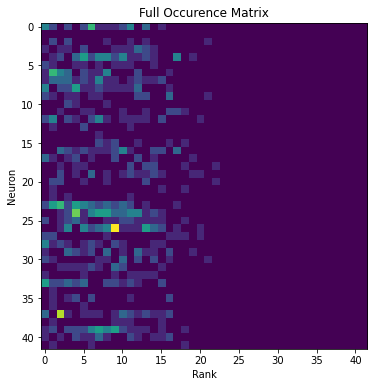

In [45]:
new_starting_points = np.delete(starting_points, 4, 1)
ranks_whole_sess = np.array(
    [
        [
            [
                URI.firing_ranks(
                    spk_matrix2spk_time(
                        spike_matrices[i, j, k], get_bins(new_starting_points[j, i])
                    )
                )
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
print(ranks_whole_sess.shape)
occ_whole_sess = np.array(
    [
        [
            [URI.firing_ranks2occ_matrix(ranks_whole_sess[i, j, k]) for k in range(2)]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
print(occ_whole_sess.shape)

plt.figure(figsize=(6, 6))
plt.imshow(occ_whole_sess[0, 0, 0])
plt.xlabel("Rank")
plt.ylabel("Neuron")
plt.title("Full Occurence Matrix")
plt.show()

In [46]:
def get_reduced_occ(occ, seq):
    return occ[seq]

(20, 2, 2)
[41 30]


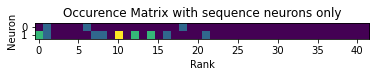

In [47]:
# sequences = np.array([[[URI_extra.construct_sequence(ranks_whole_sess[i, j, k], spike_matrices[i, j, k].shape[1], 200) for k in range(2)] for j in range(2)] for i in range(20)])
# np.save('sequences', sequences)
# 81m 23.2s (200)
sequences = np.load("sequences.npy", allow_pickle=True)
print(sequences.shape)
print(sequences[0, 0, 0])

plt.figure(figsize=(6, 6))
plt.imshow(get_reduced_occ(occ_whole_sess[0, 0, 0], sequences[0, 0, 0]))
plt.xlabel("Rank")
plt.ylabel("Neuron")
plt.title("Occurence Matrix with sequence neurons only")
plt.show()

In [48]:
both_sign_learned = np.delete(learned[72:, 0], 4).astype(int)
both_sign_notlearned = np.logical_not(both_sign_learned)
both_sign_learned = np.where(both_sign_learned)
both_sign_notlearned = np.where(both_sign_notlearned)

In [49]:
from scipy.stats.stats import pearsonr

In [50]:
occ_whole_sess_reduced = np.array(
    [
        [
            [
                get_reduced_occ(occ_whole_sess[i, j, k], sequences[i, j, k]).flatten()
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
occ_per_trial = np.array(
    [
        [
            [
                [
                    get_reduced_occ(
                        URI.firing_ranks2occ_matrix(
                            URI.firing_ranks(
                                spk_matrix2spk_time(
                                    np.array([trial]),
                                    get_bins(new_starting_points[j, i]),
                                )
                            )
                        ),
                        sequences[i, j, k],
                    ).flatten()
                    for trial in spike_matrices[i, j, k]
                ]
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
corrs_per_trial = np.array(
    [
        [
            [
                np.nan_to_num(
                    [
                        np.corrcoef(occ_whole_sess_reduced[i, j, k], trial_occ)[0, 1]
                        for trial_occ in occ_per_trial[i, j, k]
                    ]
                )
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
corrs_across_regions = np.array(
    [
        [
            np.corrcoef(corrs_per_trial[i, 0, k], corrs_per_trial[i, 1, k])[0, 1]
            for k in range(2)
        ]
        for i in range(20)
    ]
)

C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/742465805.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  occ_whole_sess_reduced = np.array([[[get_reduced_occ(occ_whole_sess[i, j, k], sequences[i, j, k]).flatten() for k in range(2)] for j in range(2)] for i in range(20)])
C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/742465805.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  occ_per_trial = np.array([[[[get_reduced_occ(URI.firing_ranks2occ_matrix(URI.firing_ranks(spk_matrix2spk_time(np.array([trial]), get_bins(new_starting_points[j, i]))

(2, 1771)
[0.13574754 0.16462864]


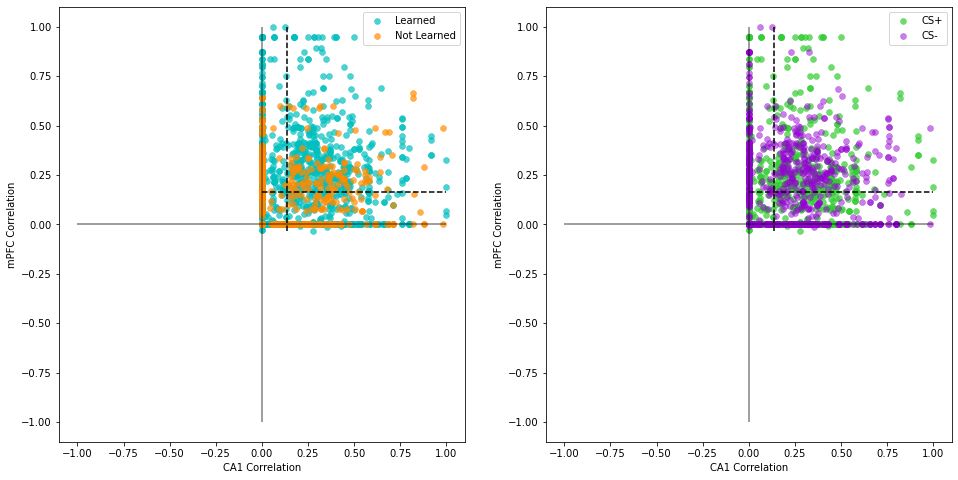

In [51]:
corr_all_trials = np.array(
    [[t for i in corrs_per_trial[:, j].flatten() for t in i] for j in range(2)]
)
corr_all_trials_learned = np.array(
    [
        [t for i in corrs_per_trial[both_sign_learned][:, j].flatten() for t in i]
        for j in range(2)
    ]
)
corr_all_trials_notlearned = np.array(
    [
        [t for i in corrs_per_trial[both_sign_notlearned][:, j].flatten() for t in i]
        for j in range(2)
    ]
)

print(corr_all_trials.shape)
medians = (
    np.median(corr_all_trials_learned, axis=1)
    + np.median(corr_all_trials_notlearned, axis=1)
) / 2
print(medians)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.vlines(
    medians[0],
    np.min(corr_all_trials[1]),
    np.max(corr_all_trials[1]),
    colors="black",
    linestyles="--",
)
plt.hlines(
    medians[1],
    np.min(corr_all_trials[0]),
    np.max(corr_all_trials[0]),
    colors="black",
    linestyles="--",
)
plt.vlines(0, -1, 1, colors="black", alpha=0.5)
plt.hlines(0, -1, 1, colors="black", alpha=0.5)
plt.scatter(
    corr_all_trials_learned[0],
    corr_all_trials_learned[1],
    linewidths=0.5,
    color="c",
    alpha=0.7,
    label="Learned",
)
plt.scatter(
    corr_all_trials_notlearned[0],
    corr_all_trials_notlearned[1],
    linewidths=0.5,
    color="darkorange",
    alpha=0.7,
    label="Not Learned",
)
plt.xlabel("CA1 Correlation")
plt.ylabel("mPFC Correlation")
plt.legend()

corr_all_trials_plus = np.array(
    [[t for i in corrs_per_trial[:, j, 0].flatten() for t in i] for j in range(2)]
)
corr_all_trials_minus = np.array(
    [[t for i in corrs_per_trial[:, j, 1].flatten() for t in i] for j in range(2)]
)
plt.subplot(122)
plt.vlines(
    medians[0],
    np.min(corr_all_trials[1]),
    np.max(corr_all_trials[1]),
    colors="black",
    linestyles="--",
)
plt.hlines(
    medians[1],
    np.min(corr_all_trials[0]),
    np.max(corr_all_trials[0]),
    colors="black",
    linestyles="--",
)
plt.vlines(0, -1, 1, colors="black", alpha=0.5)
plt.hlines(0, -1, 1, colors="black", alpha=0.5)
plt.scatter(
    corr_all_trials_plus[0],
    corr_all_trials_plus[1],
    linewidths=0.5,
    color="limegreen",
    alpha=0.7,
    label="CS+",
)
plt.scatter(
    corr_all_trials_minus[0],
    corr_all_trials_minus[1],
    linewidths=0.5,
    color="darkviolet",
    alpha=0.5,
    label="CS-",
)
plt.xlabel("CA1 Correlation")
plt.ylabel("mPFC Correlation")
plt.legend()
plt.show()

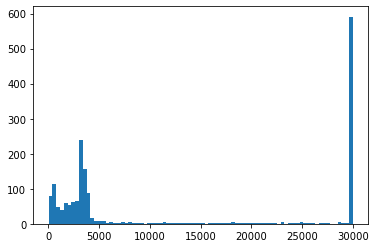

(-0.027085937081949236, 0.25459118316153967)
(0.033077181667542706, 0.16410621299941633)
(-0.1020791778394374, 1.6771319205167946e-05)
(0.09486638769156427, 6.374851042033642e-05)
(0.05464900895477988, 0.02145371977920773)

(-0.03565711436384484, 0.13361833995415673)
(0.11020847656002584, 3.338338472304689e-06)
(-0.10238388657884652, 1.581977760231043e-05)
(-0.05726483462791989, 0.01594522933461587)


In [52]:
time_until_first_licks_all_trials = np.array(
    [t for i in time_until_first_licks.flatten() for t in i]
)

plt.hist(time_until_first_licks_all_trials, 80)
# plt.xlim((0, 4900))
plt.show()

print(pearsonr(corr_all_trials[0], corr_all_trials[1]))
print(pearsonr(corr_all_trials[0], time_until_first_licks_all_trials))
print(pearsonr(corr_all_trials[1], time_until_first_licks_all_trials))
print(
    pearsonr(corr_all_trials[0] - corr_all_trials[1], time_until_first_licks_all_trials)
)
print(
    pearsonr(
        corr_all_trials[0] * (1 - corr_all_trials[1]), time_until_first_licks_all_trials
    )
)

print()
did_lick = np.empty(time_until_first_licks_all_trials.shape)
did_lick[time_until_first_licks_all_trials <= 5000] = 1
did_lick[time_until_first_licks_all_trials > 5000] = 0

print(pearsonr(corr_all_trials[0], did_lick))
print(pearsonr(corr_all_trials[1], did_lick))
print(pearsonr(corr_all_trials[0] - corr_all_trials[1], did_lick))
print(pearsonr(corr_all_trials[0] * (1 - corr_all_trials[1]), did_lick))

In [53]:
from scipy.stats import spearmanr

In [54]:
occ_whole_sess_reduced = np.array(
    [
        [
            [
                get_reduced_occ(occ_whole_sess[i, j, k], sequences[i, j, k]).flatten()
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
occ_per_trial = np.array(
    [
        [
            [
                [
                    get_reduced_occ(
                        URI.firing_ranks2occ_matrix(
                            URI.firing_ranks(
                                spk_matrix2spk_time(
                                    np.array([trial]),
                                    get_bins(new_starting_points[j, i]),
                                )
                            )
                        ),
                        sequences[i, j, k],
                    ).flatten()
                    for trial in spike_matrices[i, j, k]
                ]
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
corrs_per_trial = np.array(
    [
        [
            [
                np.nan_to_num(
                    [
                        spearmanr(occ_whole_sess_reduced[i, j, k], trial_occ)[0]
                        for trial_occ in occ_per_trial[i, j, k]
                    ]
                )
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)

C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/1204529518.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  occ_whole_sess_reduced = np.array([[[get_reduced_occ(occ_whole_sess[i, j, k], sequences[i, j, k]).flatten() for k in range(2)] for j in range(2)] for i in range(20)])
C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/1204529518.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  occ_per_trial = np.array([[[[get_reduced_occ(URI.firing_ranks2occ_matrix(URI.firing_ranks(spk_matrix2spk_time(np.array([trial]), get_bins(new_starting_points[j, i]

(2, 1771)
[0.18887198 0.17963271]
[0.15257903 0.14745901]
(2, 1771)
[0.20638825 0.18838084]


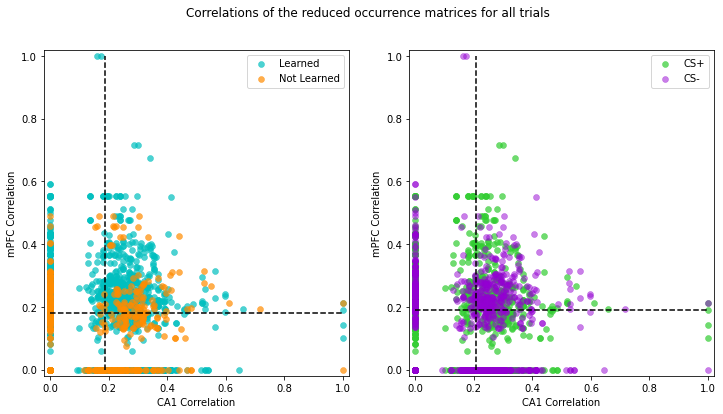

In [55]:
corr_all_trials = np.array(
    [[t for i in corrs_per_trial[:, j].flatten() for t in i] for j in range(2)]
)
corr_all_trials_learned = np.array(
    [
        [t for i in corrs_per_trial[both_sign_learned][:, j].flatten() for t in i]
        for j in range(2)
    ]
)
corr_all_trials_notlearned = np.array(
    [
        [t for i in corrs_per_trial[both_sign_notlearned][:, j].flatten() for t in i]
        for j in range(2)
    ]
)

print(corr_all_trials.shape)
medians = (
    np.median(corr_all_trials_learned, axis=1)
    + np.median(corr_all_trials_notlearned, axis=1)
) / 2
print(medians)
print(np.std(corr_all_trials, axis=1))

plt.figure(figsize=(12, 6))
plt.suptitle("Correlations of the reduced occurrence matrices for all trials")
plt.subplot(121)
plt.vlines(
    medians[0],
    np.min(corr_all_trials[1]),
    np.max(corr_all_trials[1]),
    colors="black",
    linestyles="--",
)
plt.hlines(
    medians[1],
    np.min(corr_all_trials[0]),
    np.max(corr_all_trials[0]),
    colors="black",
    linestyles="--",
)
plt.scatter(
    corr_all_trials_learned[0],
    corr_all_trials_learned[1],
    linewidths=0.5,
    color="c",
    alpha=0.7,
    label="Learned",
)
plt.scatter(
    corr_all_trials_notlearned[0],
    corr_all_trials_notlearned[1],
    linewidths=0.5,
    color="darkorange",
    alpha=0.7,
    label="Not Learned",
)
plt.xlabel("CA1 Correlation")
plt.ylabel("mPFC Correlation")
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()

corr_all_trials_plus = np.array(
    [[t for i in corrs_per_trial[:, j, 0].flatten() for t in i] for j in range(2)]
)
corr_all_trials_minus = np.array(
    [[t for i in corrs_per_trial[:, j, 1].flatten() for t in i] for j in range(2)]
)

print(corr_all_trials.shape)
medians = (
    np.median(corr_all_trials_plus, axis=1) + np.median(corr_all_trials_minus, axis=1)
) / 2
print(medians)

plt.subplot(122)
plt.vlines(
    medians[0],
    np.min(corr_all_trials[1]),
    np.max(corr_all_trials[1]),
    colors="black",
    linestyles="--",
)
plt.hlines(
    medians[1],
    np.min(corr_all_trials[0]),
    np.max(corr_all_trials[0]),
    colors="black",
    linestyles="--",
)
plt.scatter(
    corr_all_trials_plus[0],
    corr_all_trials_plus[1],
    linewidths=0.5,
    color="limegreen",
    alpha=0.7,
    label="CS+",
)
plt.scatter(
    corr_all_trials_minus[0],
    corr_all_trials_minus[1],
    linewidths=0.5,
    color="darkviolet",
    alpha=0.5,
    label="CS-",
)
plt.xlabel("CA1 Correlation")
plt.ylabel("mPFC Correlation")
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()
plt.show()

In [56]:
print(np.mean(corr_all_trials, axis=1))
print(np.median(corr_all_trials, axis=1))

[0.1726471  0.17264269]
[0.20500178 0.19114292]


C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/1396402416.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array([corr_all_trials_learned[0], corr_all_trials_notlearned[0]]), 30, color=['c', 'darkorange'])
C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/1396402416.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array([corr_all_trials_learned[1], corr_all_trials_notlearned[1]]), 30, color=['c', 'darkorange'])
C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/1396402416.py:9: VisibleDeprecationWarning: Creating an nd

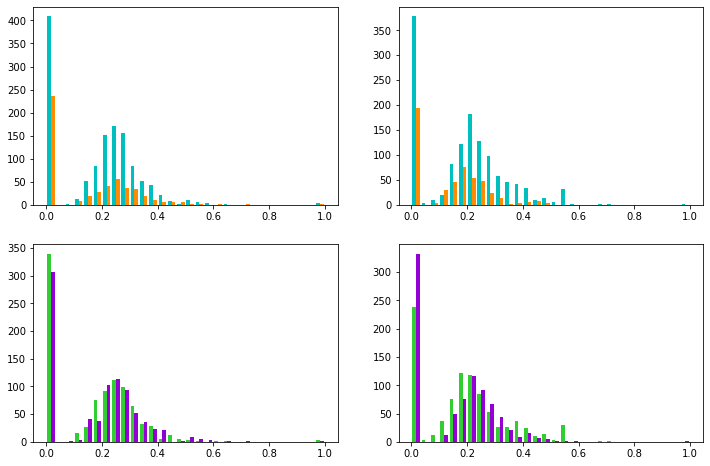

In [57]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.hist(
    np.array([corr_all_trials_learned[0], corr_all_trials_notlearned[0]]),
    30,
    color=["c", "darkorange"],
)

plt.subplot(222)
plt.hist(
    np.array([corr_all_trials_learned[1], corr_all_trials_notlearned[1]]),
    30,
    color=["c", "darkorange"],
)

plt.subplot(223)
plt.hist(
    np.array([corr_all_trials_plus[0], corr_all_trials_minus[0]]),
    30,
    color=["limegreen", "darkviolet"],
)

plt.subplot(224)
plt.hist(
    np.array([corr_all_trials_plus[1], corr_all_trials_minus[1]]),
    30,
    color=["limegreen", "darkviolet"],
)
plt.show()

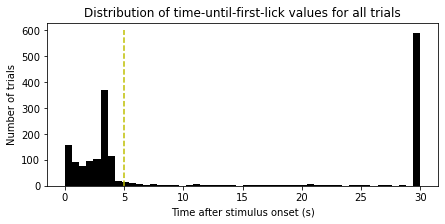

(-0.034571459337641504, 0.1458667831005094)
(0.02990308929666325, 0.2084597637696889)
(-0.13807061128093512, 5.401009548583766e-09)
(-0.0549257781946673, 0.020801483261050944)

(-0.03572891300095675, 0.13283721955363104)
(0.14991625730972857, 2.2921119353875712e-10)
(0.05556762832928386, 0.019354986110810175)

0.585544889892716


In [58]:
time_until_first_licks_all_trials = np.array(
    [t for i in time_until_first_licks.flatten() for t in i]
)

plt.figure(figsize=(7, 3))
plt.hist(time_until_first_licks_all_trials / 1000, 50, color="black")
plt.vlines(5, 0, 600, color="y", linestyle="--")
plt.title("Distribution of time-until-first-lick values for all trials")
plt.xlabel("Time after stimulus onset (s)")
plt.ylabel("Number of trials")
plt.show()

print(pearsonr(corr_all_trials[0], corr_all_trials[1]))
print(pearsonr(corr_all_trials[0], time_until_first_licks_all_trials))
print(pearsonr(corr_all_trials[1], time_until_first_licks_all_trials))
print(
    pearsonr(corr_all_trials[0] * corr_all_trials[1], time_until_first_licks_all_trials)
)
# print(pearsonr(corr_all_trials[0] * (1-corr_all_trials[1]), time_until_first_licks_all_trials))

print()
did_lick = np.zeros(time_until_first_licks_all_trials.shape)
did_lick[time_until_first_licks_all_trials <= 5000] = 1

print(pearsonr(corr_all_trials[0], did_lick))
print(pearsonr(corr_all_trials[1], did_lick))
print(pearsonr(corr_all_trials[0] * corr_all_trials[1], did_lick))
# print(pearsonr(corr_all_trials[0] * (1-corr_all_trials[1]), did_lick))
print()
print(np.sum(did_lick) / len(did_lick))

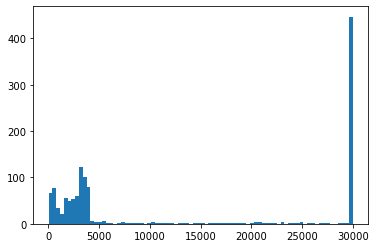

(-0.0749174814359782, 0.007707201023057058)
(0.04682977675672665, 0.09607357591424281)
(-0.1342852063947862, 1.6578336317757235e-06)
(0.12443396005755955, 9.12847971200006e-06)
(0.07079923487557567, 0.011809738260673427)

(-0.04907849517768492, 0.08112394010617328)
(0.14681253739009376, 1.581048019823262e-07)
(-0.13461891756836766, 1.5613408206306726e-06)
(-0.07244790864933981, 0.009978820744822875)



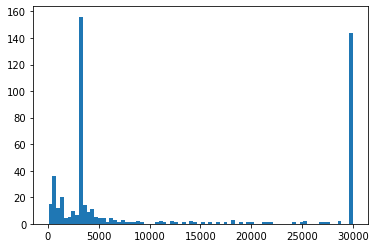

(0.011620406093761344, 0.7940803856325864)
(-0.029520420899186942, 0.5071991595879537)
(-0.1939938161292575, 1.0866519977372702e-05)
(0.09658232504469116, 0.029672919503752337)
(-0.009434754698477881, 0.8321698178806833)

(0.0022661455686700215, 0.9594050867975282)
(0.18368369524447642, 3.1659119520986197e-05)
(-0.1118172757815894, 0.011754082386960277)
(-0.020441437199006707, 0.6461014660409058)


In [59]:
time_until_first_licks_learned = np.array(
    [t for i in time_until_first_licks[both_sign_learned].flatten() for t in i]
)

plt.hist(time_until_first_licks_learned, 80)
plt.show()

print(pearsonr(corr_all_trials_learned[0], corr_all_trials_learned[1]))
print(pearsonr(corr_all_trials_learned[0], time_until_first_licks_learned))
print(pearsonr(corr_all_trials_learned[1], time_until_first_licks_learned))
print(
    pearsonr(
        corr_all_trials_learned[0] - corr_all_trials_learned[1],
        time_until_first_licks_learned,
    )
)
print(
    pearsonr(
        corr_all_trials_learned[0] * (1 - corr_all_trials_learned[1]),
        time_until_first_licks_learned,
    )
)

print()
did_lick_learned = np.zeros(time_until_first_licks_learned.shape)
did_lick_learned[time_until_first_licks_learned <= 5000] = 1

print(pearsonr(corr_all_trials_learned[0], did_lick_learned))
print(pearsonr(corr_all_trials_learned[1], did_lick_learned))
print(
    pearsonr(corr_all_trials_learned[0] - corr_all_trials_learned[1], did_lick_learned)
)
print(
    pearsonr(
        corr_all_trials_learned[0] * (1 - corr_all_trials_learned[1]), did_lick_learned
    )
)


print()

time_until_first_licks_notlearned = np.array(
    [t for i in time_until_first_licks[both_sign_notlearned].flatten() for t in i]
)

plt.hist(time_until_first_licks_notlearned, 80)
plt.show()

print(pearsonr(corr_all_trials_notlearned[0], corr_all_trials_notlearned[1]))
print(pearsonr(corr_all_trials_notlearned[0], time_until_first_licks_notlearned))
print(pearsonr(corr_all_trials_notlearned[1], time_until_first_licks_notlearned))
print(
    pearsonr(
        corr_all_trials_notlearned[0] - corr_all_trials_notlearned[1],
        time_until_first_licks_notlearned,
    )
)
print(
    pearsonr(
        corr_all_trials_notlearned[0] * (1 - corr_all_trials_notlearned[1]),
        time_until_first_licks_notlearned,
    )
)

print()
did_lick_notlearned = np.zeros(time_until_first_licks_notlearned.shape)
did_lick_notlearned[time_until_first_licks_notlearned <= 5000] = 1

print(pearsonr(corr_all_trials_notlearned[0], did_lick_notlearned))
print(pearsonr(corr_all_trials_notlearned[1], did_lick_notlearned))
print(
    pearsonr(
        corr_all_trials_notlearned[0] - corr_all_trials_notlearned[1],
        did_lick_notlearned,
    )
)
print(
    pearsonr(
        corr_all_trials_notlearned[0] * (1 - corr_all_trials_notlearned[1]),
        did_lick_notlearned,
    )
)

In [60]:
occ_whole_sess_reduced = np.array(
    [
        [[occ_whole_sess[i, j, k].flatten() for k in range(2)] for j in range(2)]
        for i in range(20)
    ]
)
occ_per_trial = np.array(
    [
        [
            [
                [
                    URI.firing_ranks2occ_matrix(
                        URI.firing_ranks(
                            spk_matrix2spk_time(
                                np.array([trial]), get_bins(new_starting_points[j, i])
                            )
                        )
                    ).flatten()
                    for trial in spike_matrices[i, j, k]
                ]
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)
corrs_per_trial = np.array(
    [
        [
            [
                np.nan_to_num(
                    [
                        spearmanr(occ_whole_sess_reduced[i, j, k], trial_occ)[0]
                        for trial_occ in occ_per_trial[i, j, k]
                    ]
                )
                for k in range(2)
            ]
            for j in range(2)
        ]
        for i in range(20)
    ]
)

C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/749351704.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  occ_whole_sess_reduced = np.array([[[occ_whole_sess[i, j, k].flatten() for k in range(2)] for j in range(2)] for i in range(20)])
C:\Users\reubi\AppData\Local\Temp/ipykernel_10944/749351704.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  occ_per_trial = np.array([[[[URI.firing_ranks2occ_matrix(URI.firing_ranks(spk_matrix2spk_time(np.array([trial]), get_bins(new_starting_points[j, i])))).flatten() for trial in spike_matrices[i, j, k]] fo

(2, 1771)
[0.216793   0.18965972]
(2, 1771)
[0.21627522 0.1924571 ]


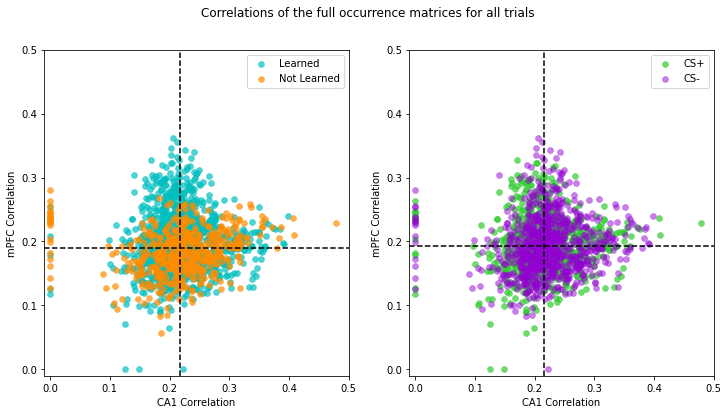

In [61]:
corr_all_trials = np.array(
    [[t for i in corrs_per_trial[:, j].flatten() for t in i] for j in range(2)]
)
corr_all_trials_learned = np.array(
    [
        [t for i in corrs_per_trial[both_sign_learned][:, j].flatten() for t in i]
        for j in range(2)
    ]
)
corr_all_trials_notlearned = np.array(
    [
        [t for i in corrs_per_trial[both_sign_notlearned][:, j].flatten() for t in i]
        for j in range(2)
    ]
)

print(corr_all_trials.shape)
medians = (
    np.median(corr_all_trials_learned, axis=1)
    + np.median(corr_all_trials_notlearned, axis=1)
) / 2
print(medians)

plt.figure(figsize=(12, 6))
plt.suptitle("Correlations of the full occurrence matrices for all trials")
plt.subplot(121)
plt.vlines(medians[0], -0.01, 0.5, colors="black", linestyles="--")
plt.hlines(medians[1], -0.01, 0.5, colors="black", linestyles="--")
plt.scatter(
    corr_all_trials_learned[0],
    corr_all_trials_learned[1],
    linewidths=0.5,
    color="c",
    alpha=0.7,
    label="Learned",
)
plt.scatter(
    corr_all_trials_notlearned[0],
    corr_all_trials_notlearned[1],
    linewidths=0.5,
    color="darkorange",
    alpha=0.7,
    label="Not Learned",
)
plt.xlabel("CA1 Correlation")
plt.ylabel("mPFC Correlation")
plt.xlim(-0.01, 0.5)
plt.ylim(-0.01, 0.5)
plt.legend()

corr_all_trials_plus = np.array(
    [[t for i in corrs_per_trial[:, j, 0].flatten() for t in i] for j in range(2)]
)
corr_all_trials_minus = np.array(
    [[t for i in corrs_per_trial[:, j, 1].flatten() for t in i] for j in range(2)]
)

print(corr_all_trials.shape)
medians = (
    np.median(corr_all_trials_plus, axis=1) + np.median(corr_all_trials_minus, axis=1)
) / 2
print(medians)

plt.subplot(122)
plt.vlines(medians[0], -0.01, 0.5, colors="black", linestyles="--")
plt.hlines(medians[1], -0.01, 0.5, colors="black", linestyles="--")
plt.scatter(
    corr_all_trials_plus[0],
    corr_all_trials_plus[1],
    linewidths=0.5,
    color="limegreen",
    alpha=0.7,
    label="CS+",
)
plt.scatter(
    corr_all_trials_minus[0],
    corr_all_trials_minus[1],
    linewidths=0.5,
    color="darkviolet",
    alpha=0.5,
    label="CS-",
)
plt.xlabel("CA1 Correlation")
plt.ylabel("mPFC Correlation")
plt.xlim(-0.01, 0.5)
plt.ylim(-0.01, 0.5)
plt.legend()
plt.show()

In [62]:
print(np.mean(corr_all_trials, axis=1))
print(np.median(corr_all_trials, axis=1))

[0.21887851 0.195411  ]
[0.21616002 0.19256158]


On 1000 surrogates:

CS+
0   [0.251 0.339 0.802 0.36  0.237 0.335 0.018 0.204 0.577 0.151 0.148 0.767
12   0.784 0.133 0.621 0.129 0.637 0.011 0.306 0.049 0.767 0.759 0.611 0.854
24   0.755 0.12  0.581 0.726 0.946 0.485 0.25  0.88  0.206 0.82  0.294 0.531
36   0.436 0.988 0.352 0.358 0.349 0.817 0.354 0.252 0.89  0.073 0.849 0.308
48   0.03  0.159 0.301 0.216 0.119 0.745 0.823 0.571 0.802 0.307 0.047 0.
60   0.247 0.476 0.133 0.359 0.21  0.278 0.571 0.081 0.006 0.144 0.617 0.326
72   0.152 0.812 0.378 0.019 0.385 0.887 0.355 0.056 0.142 0.026 0.326 0.622
84   0.846 0.465 0.045 0.129 0.001 0.458 0.227 0.401 0.052]

CS-
0   [0.769 0.429 0.99  0.342 0.012 0.207 0.069 0.126 0.53  0.779 0.002 0.223
12   0.076 0.844 0.86  0.194 0.238 0.018 0.389 0.    0.222 0.017 0.062 0.528
24   0.99  0.588 0.07  0.564 0.022 0.271 0.254 0.068 0.794 0.13  0.254 0.193
36   0.211 0.21  0.516 0.848 0.571 0.299 0.041 0.771 0.395 0.454 0.947 0.707
48   0.766 0.017 0.664 0.148 0.023 0.166 0.524 0.262 0.028 0.567 0.224 0.066
60   0.17  0.586 0.065 0.222 0.017 0.022 0.037 0.81  0.227 0.121 0.068 0.182
72   0.784 0.154 0.847 0.573 0.856 0.345 0.31  0.129 0.233 0.339 0.626 0.188
84   0.823 0.6   0.52  0.759 0.028 0.682 0.028 0.201 0.486]

p <= 0.05
CS+: 6, 17, 19, 48, 58, 59, 68, 75, 81, 86, 88
CS-: 4, 10, 17, 19, 21, 28, 42, 49, 52, 56, 64, 65, 66, 88

p <= 0.02
CS+: 6, 17, 59, 68, 75, 88
CS-: 4, 10, 17, 19, 21, 49, 64, 88

Both: 17, 19, 88

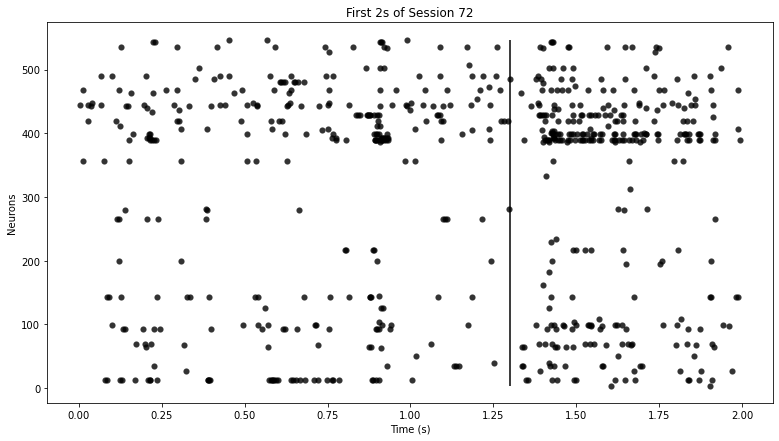

In [63]:
plt.figure(figsize=(13, 7))
cur = data[72]["Spikes"]
plt.scatter(
    cur[0][cur[0] / srate < 2] / srate,
    cur[1][cur[0] / srate < 2],
    linewidths=0.1,
    alpha=0.8,
    color="black",
)
plt.vlines(
    1.3,
    np.min(cur[1][cur[0] / srate < 2]),
    np.max(cur[1][cur[0] / srate < 2]),
    color="black",
)
plt.title("First 2s of Session 72")
plt.ylabel("Neurons")
plt.xlabel("Time (s)")
plt.show()

In [64]:
# ttime = data[s]['Spikes'][0][-1]/srate*1000 # in ms
# for ibin, bin_start in enumerate(bins+stim):
#     bin_end = bin_start+bin_width

#     idx = data[s]['Spikes'][1]== neuron_id
#     count  = np.sum(np.logical_and(data[s]['Spikes'][0][idx]>bin_start, data[s]['Spikes'][0][idx]< bin_end))

#     spk_matrix[istim,ineuron,ibin] = count
#     # print(len(np.where(np.logical_and(data[s]['Spikes'][0][idx]>bin_start, data[s]['Spikes'][0][idx]< bin_end))[0]))

In [65]:
# print(CS_plus_URI[1])
# print(CS_minus_URI[1])
# plt.imshow(CS_plus_URI[2])
# plt.colorbar()
# plt.show()
# plt.imshow(CS_minus_URI[2])
# plt.colorbar()
# plt.show()

In [66]:
# cs_plus_p_values = np.empty(ses.shape)
# cs_minus_p_values = np.empty(ses.shape)
# for sess in range(len(data)):
#     cs_plus_p_values[sess] = get_pvalue(data, sess, 1)
#     cs_minus_p_values[sess] = get_pvalue(data, sess, 2)
# print(cs_plus_p_values)
# print(cs_minus_p_values)

In [67]:
# window = 50
# window_bins = np.arange(bins[0], bins[-1]-window, 25)-bins[0]

# CS_plus_URIs = np.empty(len(window_bins))
# CS_minus_URIs = np.empty(len(window_bins))
# CS_plus_p_values = np.empty(len(window_bins))
# CS_minus_p_values = np.empty(len(window_bins))
# for istart, start in enumerate(window_bins):
#     CS_plus_spk_time = spk_matrix2spk_time(CS_plus_spk_matrix[:, :, start:start+window], bins[start:start+window])
#     CS_minus_spk_time = spk_matrix2spk_time(CS_minus_spk_matrix[:, :, start:start+window], bins[start:start+window])
#     uri1 = URI.getURI(CS_plus_spk_time, 100)
#     uri2 = URI.getURI(CS_minus_spk_time, 100)
#     CS_plus_URIs[istart] = (uri1[0]-np.mean(uri1[3]))/np.std(uri1[3])
#     CS_minus_URIs[istart] = (uri2[0]-np.mean(uri2[3]))/np.std(uri2[3])
#     CS_plus_p_values[istart] = uri1[1]
#     CS_minus_p_values[istart] = uri2[1]

In [68]:
# plt.plot(window_bins, CS_plus_URIs)
# plt.plot(window_bins, CS_minus_URIs)
# plt.plot(window_bins[CS_plus_p_values<0.05], CS_plus_p_values[CS_plus_p_values<0.05]*0+1, '.')
# plt.plot(window_bins[CS_minus_p_values<0.05], CS_minus_p_values[CS_minus_p_values<0.05]*0+1,'.')
# plt.show()
# print(CS_plus_URIs.shape)
# print(CS_minus_URIs.shape)